# Solución Challenge Cargo Data Scientist LATAM Airlines
### Autor: Ignacio Loayza Campos

__Información de contacto:__
> - Correo: ignacio.1505@gmail.com
> - usr Github: @TattooeDeer


Voy a comenzar con un EDA básico sobre los datos para ver problemas que puedan venir referentes a los tipos de datos, codificaciones, valores nulos, etc.

In [95]:
## Manejo de datos
import pandas as pd
import numpy as np

## Visuales y graficos
import matplotlib.pyplot as plt 
import seaborn as sn
plt.rcParams['figure.figsize'] = (15,10)
## Modelacion
# Comencemos por ahora con algo light, solo un par de modelos con hipotesis distintas para ver que tan bien
# se manejan con los atributos de la primera iteracion de ingenieria de atributos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB



In [2]:
df = pd.read_csv('dataset_SCL.csv')

/home/ignacio/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# EDA

Parece haber algunos problemas de formato con los valores en algunas columnas que hacen que pandas no pueda interpretar el tipo de dato correctamente

In [3]:
df.sample(10)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
44702,2017-09-01 20:40:00,146,SCEL,KATL,DAL,2017-09-01 20:34:00,146,SCEL,KATL,DAL,1,9,2017,Viernes,I,Delta Air,Santiago,Atlanta
39608,2017-08-14 04:55:00,9673,SCEL,SBGR,TAM,2017-08-14 05:00:00,9673,SCEL,SBGR,TAM,14,8,2017,Lunes,I,Grupo LATAM,Santiago,Sao Paulo
36115,2017-07-01 12:40:00,273,SCEL,SCTE,LAN,2017-07-01 12:41:00,273,SCEL,SCTE,LXP,1,7,2017,Sabado,N,Grupo LATAM,Santiago,Puerto Montt
30733,2017-06-01 18:00:00,318,SCEL,SCAT,LAN,2017-06-01 18:16:00,318,SCEL,SCAT,LXP,1,6,2017,Jueves,N,Grupo LATAM,Santiago,Copiapo
50863,2017-10-26 08:15:00,1,SCEL,SCTE,SKU,2017-10-26 08:40:00,1,SCEL,SCTE,SKU,26,10,2017,Jueves,N,Sky Airline,Santiago,Puerto Montt
58484,2017-11-15 17:14:00,138,SCEL,SCFA,LAN,2017-11-15 17:54:00,138,SCEL,SCFA,LAN,15,11,2017,Miercoles,N,Grupo LATAM,Santiago,Antofagasta
43721,2017-08-23 19:00:00,1446,SCEL,SEGU,LAN,2017-08-23 19:01:00,1446,SCEL,SEGU,LNE,23,8,2017,Miercoles,I,Grupo LATAM,Santiago,Guayaquil
46995,2017-09-23 15:25:00,174,SCEL,SCDA,LAN,2017-09-23 15:34:00,174,SCEL,SCDA,LAN,23,9,2017,Sabado,N,Grupo LATAM,Santiago,Iquique
52918,2017-10-20 19:32:00,217,SCEL,SCIE,LAN,2017-10-20 21:12:00,217,SCEL,SCIE,LXP,20,10,2017,Viernes,N,Grupo LATAM,Santiago,Concepcion
36212,2017-07-20 05:30:00,281,SCEL,SCCI,LAN,2017-07-20 05:34:00,281,SCEL,SCCI,LXP,20,7,2017,Jueves,N,Grupo LATAM,Santiago,Punta Arenas


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


Según el contexto entregado, la mayoría de las columnas por las que pandas arrojó el warning corresponden a códigos, probablemente lo que ocurrió fue que vió tanto números como códigos alfanuméricos y no pudo coercionar todos los valores a int/float, puesto que esos códigos son variables categóricas voy a dejarlos como tipo de dato `object`.

Las columnas `Fecha-O` y `Fecha-I` conviene tenerlas en un tipo de dato de fecha para poder aprovechar luego la lógica de distancia entre fechas/horas y calcular el atraso:

In [5]:
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])

Ahora, imagino que la información de un _"Vuelo Programado"__ es aquella referente al cómo estaba planificado que se realizace cierto vuelo mientras que la información de _"Vuelo de Operación"_ se refiere a lo que ocurrió realmente, considerando cambios que pudieron haberse hecho desde que se planificó el vuelo hasta que se efectuó. Me interesa primero ver hasta que punto el __número de vuelo__ funciona como llave para unir ambas mitades de la información asi que voy a ver cuantos números de vuelo aparecen en la columna `Vlo-I` y no aparecen en `Vlo-O`. 

In [6]:
symmetricDiff_FlightNumbers = set(df['Vlo-I']).symmetric_difference(set(df['Vlo-O']))
len(symmetricDiff_FlightNumbers)

139

Comparemos esta cantidad con la cantidad de números distintos de vuelos programados y operados

In [7]:
df['Vlo-I'].nunique()

750

In [8]:
df['Vlo-O'].nunique()

866

No es una cantidad tan despreciable como esperaba pero considerando que tenemos que apuntar a modelar la probabilidad de atraso para un vuelo dado, tendré que asumir por ahora perder esos vuelos (no puedo saber si hubo atraso si no veo el mismo número de vuelo en ambas columnas, sigo asumiendo que puede ser usado como llave). Antes de eliminar esas filas, voy a verificar datos nulos en la matriz en general y si es que hay algún tipo de sesgo en ese subconjunto de números de vuelos que no están en ambas columnas de operacion y programado (ciertas ciudades en especial, ciertas aerolíneas, etc. dimensiones que puedan hacerme perder clases que mostrarle al modelo).

In [9]:
df.isna().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

Super, prácticamente limpio de datos nulos (hasta ahora no he visto algún tipo de codificación rara para datos nulos en esta matriz y tampoco se mencionó en el enunciado).

In [10]:
excluded_flights = df[df['Vlo-I'].isin(symmetricDiff_FlightNumbers) | df['Vlo-O'].isin(symmetricDiff_FlightNumbers)]

In [11]:
excluded_flights.describe(include = 'all').replace({np.nan: '-'})

/tmp/ipykernel_198/3470436840.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  excluded_flights.describe(include = 'all').replace({np.nan: '-'})


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
count,1789,1789,1789,1789,1789,1789,1788,1789,1789,1789,1789.0,1789.0,1789.0,1789,1789,1789,1789,1789
unique,1697,122,1,32,11,1753,130,1,33,12,-,-,-,7,2,10,1,32
top,2017-12-28 13:00:00,168,SCEL,SCDA,LAN,2017-12-22 05:57:00,170.0,SCEL,SCDA,LAN,-,-,-,Viernes,N,Grupo LATAM,Santiago,Iquique
freq,3,43,1789,288,1161,2,43,1789,288,752,-,-,-,319,1458,1164,1789,288
first,2017-01-05 07:05:00,-,-,-,-,2017-01-05 09:36:00,-,-,-,-,-,-,-,-,-,-,-,-
last,2017-12-31 22:50:00,-,-,-,-,2017-12-31 23:02:00,-,-,-,-,-,-,-,-,-,-,-,-
mean,-,-,-,-,-,-,-,-,-,-,15.914477,11.740637,2017.0,-,-,-,-,-
std,-,-,-,-,-,-,-,-,-,-,8.810264,1.482119,0.0,-,-,-,-,-
min,-,-,-,-,-,-,-,-,-,-,1.0,1.0,2017.0,-,-,-,-,-
25%,-,-,-,-,-,-,-,-,-,-,8.0,12.0,2017.0,-,-,-,-,-


In [12]:
excluded_flights['Ori-I'].value_counts()

SCEL    1789
Name: Ori-I, dtype: int64

In [13]:
excluded_flights['Ori-O'].value_counts()

SCEL    1789
Name: Ori-O, dtype: int64

In [14]:
excluded_flights['Des-I'].value_counts()

SCDA    288
SCFA    247
SCIE    210
SCCF    159
SCQP    142
SCAR    121
SAEZ    111
SCTE    111
SPJC     96
SCCI     67
SCAT     32
SAME     30
SACO     29
SCVD     24
SCPQ     23
SUMU     15
SCJO     14
SAAR     13
SCSE     11
SBFL      9
SCNT      9
SULS      6
SBGL      6
KIAH      3
KJFK      3
KATL      2
LFPG      2
SEGU      2
KMIA      1
SABE      1
KDFW      1
MMMX      1
Name: Des-I, dtype: int64

In [15]:
excluded_flights['Des-O'].value_counts()

SCDA    288
SCFA    247
SCIE    210
SCCF    159
SCQP    142
SCAR    121
SAEZ    111
SCTE    111
SPJC     96
SCCI     67
SCAT     32
SAME     30
SACO     29
SCVD     24
SCPQ     23
SUMU     15
SCJO     14
SAAR     13
SCSE     11
SBFL      9
SCNT      9
SULS      6
SBGL      6
KIAH      2
KATL      2
LFPG      2
SABE      2
KMIA      2
KJFK      2
KDFW      1
MMMX      1
SEGU      1
KIAD      1
Name: Des-O, dtype: int64

In [16]:
excluded_flights['Emp-I'].value_counts()

LAN    1161
SKU     609
LAW       3
LXP       3
UAL       3
AAL       2
AFR       2
DAL       2
AVA       2
AUT       1
LRC       1
Name: Emp-I, dtype: int64

Al parecer el patron evidente es que estos vuelos siempre eran desde la ciudad con código SCEL que es el aeropuerto Arturo Merino Benitez. ¿Quizás sacaron estos vuelos para anonimizar los datos?.


In [33]:
indices = df.index.difference(excluded_flights.index)
indx = pd.IndexSlice[indices.values]
cleaned_df = df.loc[indx]

len(cleaned_df[cleaned_df['Des-I'] == 'SCEL']) # Cantidad de vuelos con aeropuerto de origen SCEL luego de sacar los vuelos a excluir

0

Más aún, no solo todos los vuelos a excluir son del aeropuerto de origen SCEL, sino que todos los vuelos con destino SCEL son excluidos.


La gran mayoría de los vuelos que voy a tener que sacar son de LAN y de Sky Airlines, comparemos ese número con la frecuencia de esas clases en la columna original

In [18]:
df['Emp-I'].value_counts()

LAN    37611
SKU    14298
TAM     3049
ARG     1949
CMP     1850
LAW     1574
AVA     1152
JAT     1095
GLO      806
AAL      757
ACA      565
IBE      362
AFR      358
DAL      358
AMX      351
UAL      335
ONE      279
AZA      259
KLM      251
LAP      216
BAW      205
QFU      195
JMR      100
LRC       92
AUT       74
PUE       49
LXP        9
LPE        4
DSM        2
LNE        1
Name: Emp-I, dtype: int64

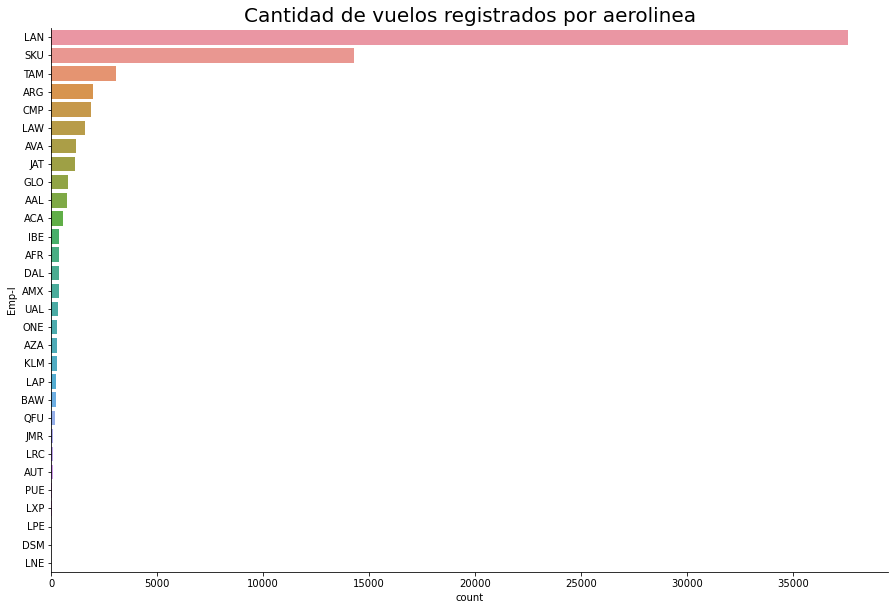

In [25]:
sn.countplot(y = 'Emp-I', data = df, order = df['Emp-I'].value_counts().index)
plt.title('Cantidad de vuelos registrados por aerolinea', fontsize = 20)
sn.despine();

LAN y SKU tienne una frecuencia considerablemente mayor por lo que al restar aquellos vuelos no debiese verse modificada de mayor forma la distirbución de frecuencia de las clases en la muestra.

Sigamos con algunas estadísitcas y distribuciones generales, de acá en adelante voy a seguir solo con el dataset limpio de los vuelos que no aparecen tanto en la columna de `Vlo-I` como en la columna de `Vlo-O`.

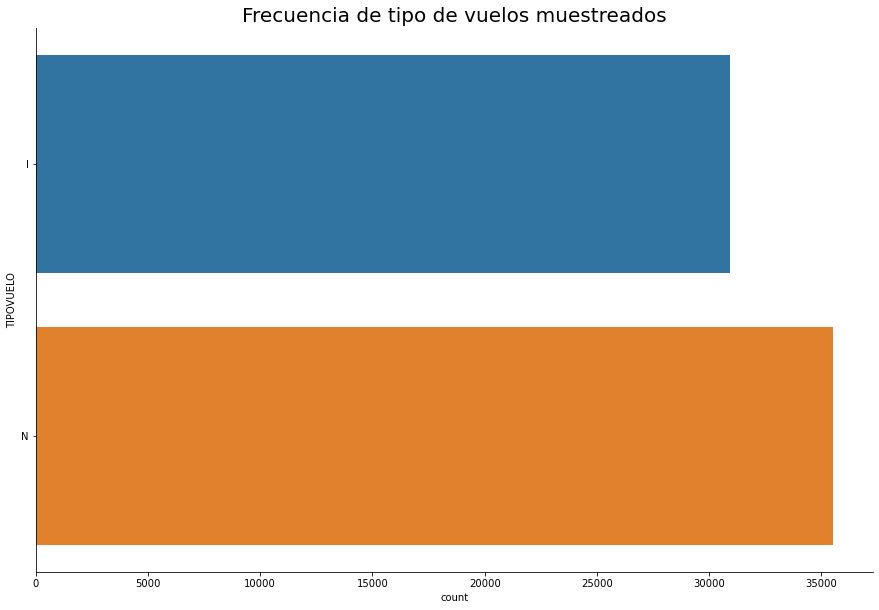

In [29]:
sn.countplot(y = 'TIPOVUELO', data = cleaned_df)
plt.title('Frecuencia de tipo de vuelos muestreados', fontsize = 20)
sn.despine()

Solo hay dos tipos de vuelo en la muestra

Vamos con algunas modas referentes a las ciudades de origen, destino y la combinación de ambas:

In [38]:
cleaned_df['SIGLAORI'].value_counts()

Santiago    66417
Name: SIGLAORI, dtype: int64

In [37]:
cleaned_df['SIGLADES'].value_counts()

Buenos Aires        6222
Antofagasta         5539
Lima                5174
Calama              4987
Puerto Montt        4246
Concepcion          3783
Sao Paulo           3569
Iquique             3459
Temuco              2447
La Serena           2399
Arica               2315
Punta Arenas        2038
Ciudad de Panama    1850
Copiapo             1748
Bogota              1604
Mendoza             1595
Rio de Janeiro      1429
Montevideo          1051
Miami               1014
Cordoba              994
Madrid               894
Balmaceda            839
Valdivia             729
Ciudad de Mexico     699
Isla de Pascua       452
Guayaquil            421
Nueva York           380
Auckland N.Z.        361
Paris                357
Atlanta              356
Dallas               356
Houston              332
Toronto              283
Roma                 259
Osorno               245
Asuncion             232
Castro (Chiloe)      212
La Paz               209
Londres              205
Sydney               194


Solo hay vuelos con origen en Santiago , sin embargo, solo hay destinos que no son esa ciudad (me imagino... ya que no se puede comprar un pasaje desde y hacia el mnismo aeropuerto).

Dia de la semana más popular para viajar en general?

In [36]:
cleaned_df['DIANOM'].value_counts()

Jueves       10011
Viernes       9973
Lunes         9880
Domingo       9532
Miercoles     9469
Martes        9415
Sabado        8137
Name: DIANOM, dtype: int64

Los jueves y viernes son los más populares. Veamos que tal es la cantidad de vuelos que se agendan por mes, para ser limpios voy a crear una columna dummy que me sirva para contar sobre la agregación:

In [40]:
cleaned_df['dummy_count'] = 1

In [44]:
grouped_year_month = cleaned_df.groupby(by = ['AÑO', 'MES'])['dummy_count'].count()
grouped_year_month

AÑO   MES
2017  1      6101
      2      5547
      3      5466
      4      5018
      5      5233
      6      4979
      7      5987
      8      5740
      9      5609
      10     6031
      11     6078
      12     4626
2018  1         2
Name: dummy_count, dtype: int64

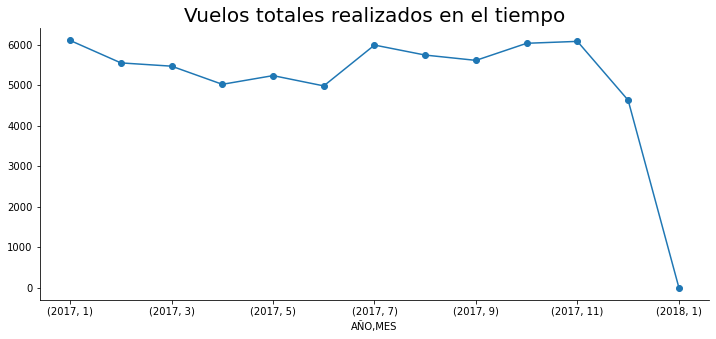

In [66]:
_, _ = plt.subplots(figsize = (12,5))

grouped_year_month.plot(marker = 'o')
plt.title('Vuelos totales realizados en el tiempo', fontsize = 20)
sn.despine();

Claramente hay una caída importante en la cantidad de vuelos operados en Diciembre de 2017 y Enero de 2018. Con respecto a diciembre tendería a pensar que puede ser porque las personas tienden a estar con sus familias en lugar de irse de vacaciones o tener vuelos de negocio, con respecto a enero todo indica que en realidad no es que hayan solo 2 vuelos, sino que los datos dejaron de medirse cuando apenas se habían registrado dos vuelos de ese mes, esto es un problema porque no quiero mostrarle a un modelo que en enero puede haber una cantidad tan baja de vuelos, para estar seguro tendría que consultar en mayor detalle a los encargados de la extracción de estos datos pero para efectos de ese ejercicio voy a hacer un salto de fe en que ese valor no corresponde a la distribución original de vuelos realizados en un mes de enero típico y voy a sacar los dos vuelos de enero del 2018. 

In [73]:
cleaned_df = cleaned_df[~((cleaned_df['AÑO'] == 2018) & (cleaned_df['MES'] == 1))]

## Columnas Sintéticas

En el enunciado se pide la creación de algunas columnas sintéticas, acá va a ser de utilidad haber convertido las columnas de fecha al formato correcto:

In [80]:
(('2017-05-01' > cleaned_df['Fecha-I']) & (cleaned_df['Fecha-I'] > '2017-03-01')).value_counts()

False    55932
True     10483
Name: Fecha-I, dtype: int64

In [96]:
cleaned_df['temporada_alta'] = np.where(
    (('2017-12-15' > cleaned_df['Fecha-I']) & (cleaned_df['Fecha-I'] > '2017-03-03')) | # entre 15-dic y 31-mar
    ((('2017-07-31' > cleaned_df['Fecha-I']) & (cleaned_df['Fecha-I'] > '2017-07-15'))) | # entre 15-jul y 31-jul 
    (('2017-09-30' > cleaned_df['Fecha-I']) & (cleaned_df['Fecha-I'] > '2017-09-11')) # entre 11-sep y 30-sep
    , 1, 0)

In [103]:
cleaned_df['dif_min'] = cleaned_df.apply(lambda x: pd.Timedelta(x['Fecha-O'] - x['Fecha-I']).seconds/3600 , axis = 1)

In [104]:
cleaned_df['atraso_15'] = np.where(cleaned_df['dif_min'] > 15, 1, 0)

Para la columna de `periodo_dia` me es más fácil hacer una función que incorpore la lógica:

In [122]:
def get_time_of_day(date_and_time):
    if (date_and_time['Fecha-I'].hour >= 5) and  (date_and_time['Fecha-I'].hour < 12):
        return 'mañana'
    elif (date_and_time['Fecha-I'].hour >= 12) and  (date_and_time['Fecha-I'].hour < 19):
        return 'tarde'
    elif (date_and_time['Fecha-I'].hour >= 19) or  (date_and_time['Fecha-I'].hour < 5):
        return 'noche'

In [125]:
cleaned_df['periodo_dia'] = cleaned_df.apply(lambda x: get_time_of_day(x), axis = 1)

Ahora almacenamos en un archivo llamado `synthetic_features.csv` como se pide:

In [127]:
cleaned_df[['temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']].to_csv('synthetic_features.csv', index = False)

## Estudio de la composición de los atrasos